<a href="https://colab.research.google.com/github/PriyadharshiniGanesh/PowerPulse-Household-Energy-Usage-Forecast/blob/main/Powerpluse_model_selection_and_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings("ignore")

import sys
import numpy as np
import random as rn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from scipy import stats as sm
from scipy.stats import zscore
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from math import sqrt
from sklearn.preprocessing import StandardScaler
import time

In [ ]:
import os
print(os.getcwd())  # Check current working directory
print(os.listdir())

/content
['.config', 'sample_data']


In [ ]:
df = pd.read_csv('household_power_consumption.txt', sep=';',low_memory=False, na_values=["?"], parse_dates={"datetime": ["Date", "Time"]}, infer_datetime_format=True)

In [ ]:
for _ in df.columns:
    df[_].fillna(df[_].median(), inplace=True)

In [ ]:
df["year"] = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month
df["day"] = df["datetime"].dt.day
df["hour"] = df["datetime"].dt.hour

Creating additional Features:

Daily Average,
Peak Hour,
and Rolling Average


In [ ]:
# Daily Average

daily_average = df.groupby(df["datetime"].dt.date)["Global_active_power"].mean()
df["daily_average"] = df["datetime"].dt.date.map(daily_average)

In [ ]:
# Peak Hour

hourly_avg = df.groupby([df["datetime"].dt.date,df["datetime"].dt.hour])["Global_active_power"].sum()
peak_hour_per_day = hourly_avg.groupby(level=0).max()
df["peak_hour"] = df["datetime"].dt.date.map(peak_hour_per_day)

In [ ]:
# Rolling Average

rolling_average = (df.groupby(df["datetime"].dt.date)["Global_active_power"].apply(lambda x: x.rolling(window=2, min_periods=1).mean()))
df["rolling_average"] = rolling_average.reset_index(drop=True)

In [ ]:
df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,year,month,day,hour,daily_average,peak_hour,rolling_average
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006,12,16,17,3.053475,217.932,4.216
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006,12,16,17,3.053475,217.932,4.788
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006,12,16,17,3.053475,217.932,5.367
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006,12,16,17,3.053475,217.932,5.381
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006,12,16,17,3.053475,217.932,4.527


Spliting Training and Test Set

In [ ]:
x = df.drop(["datetime","Global_active_power","peak_hour","rolling_average"],axis=1)
y = df["Global_active_power"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# y_train_scaled = scaler.fit_transform(y_train)
# y_test_scaled = scaler.transform(y_test)

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Neural Network': MLPRegressor(random_state=42, max_iter=1000)
}

In [ ]:
# Hyperparameter grids

param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 5, 10]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    },
    'Neural Network': {
        'hidden_layer_sizes': [(64,), (128, 64)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001]
            }
}

Build prediction model and Model comparison

In [ ]:
# Import required libraries
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import time
import gc

def evaluate(X_train, y_train, X_test, y_test):
    model_data = []
    models = [
        ['Linear: ', LinearRegression()],
        ['Lasso: ', Lasso(random_state=42)],
        ['Ridge: ', Ridge(random_state=42)],
        ['RandomForest ', RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)],
        ['GradientBoostingRegressor: ', GradientBoostingRegressor(n_estimators=50, max_depth=5, random_state=42)],
        ['AdaBoostRegressor: ', AdaBoostRegressor(n_estimators=50, random_state=42)],
        ['MLPRegressor: ', MLPRegressor(
            hidden_layer_sizes=(50,),
            activation='relu',
            solver='adam',
            max_iter=200,
            early_stopping=True,
            random_state=42
        )]
    ]

    for name, curr_model in models:
        curr_model_data = {}
        curr_model_data["Name"] = name

        start = time.time()
        curr_model.fit(X_train, y_train)
        end = time.time()

        curr_model_data["Train_Time"] = end - start
        curr_model_data["Train_R2_Score"] = r2_score(y_train, curr_model.predict(X_train))
        curr_model_data["Test_R2_Score"] = r2_score(y_test, curr_model.predict(X_test))
        curr_model_data["Test_MAE"] = mean_absolute_error(y_test, curr_model.predict(X_test))
        curr_model_data["Test_RMSE"] = np.sqrt(mean_squared_error(y_test, curr_model.predict(X_test)))

        # Handle division-by-zero in MAPE
        y_test_nonzero = np.where(y_test == 0, 1e-8, y_test)  # Avoid division by zero
        mape = 100 * np.abs((y_test - curr_model.predict(X_test)) / y_test_nonzero)
        curr_model_data["Accuracy"] = 100 - np.mean(mape)

        model_data.append(curr_model_data)
        del curr_model
        gc.collect()

    return pd.DataFrame(model_data)

# Example usage with scaling:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
results = evaluate(X_train_scaled, y_train, X_test_scaled, y_test)
print(results)

                          Name  Train_Time  Train_R2_Score  Test_R2_Score  \
0                     Linear:     0.883842        0.998547       0.998534   
1                      Lasso:     0.221216        0.093881       0.093880   
2                      Ridge:     0.165000        0.998547       0.998534   
3                RandomForest   301.236421        0.998983       0.998934   
4  GradientBoostingRegressor:   290.013519        0.999002       0.998979   
5          AdaBoostRegressor:   198.857111        0.988494       0.988505   
6               MLPRegressor:    45.177858        0.999175       0.999155   

   Test_MAE  Test_RMSE   Accuracy  
0  0.025516   0.040310  95.414837  
1  0.775444   1.002026 -59.261432  
2  0.025516   0.040310  95.414842  
3  0.019618   0.034372  97.013587  
4  0.020692   0.033643  96.404412  
5  0.089461   0.112859  76.888605  
6  0.018959   0.030607  96.667031  


Evaluating the models using  RMSE, MAE and R-squared


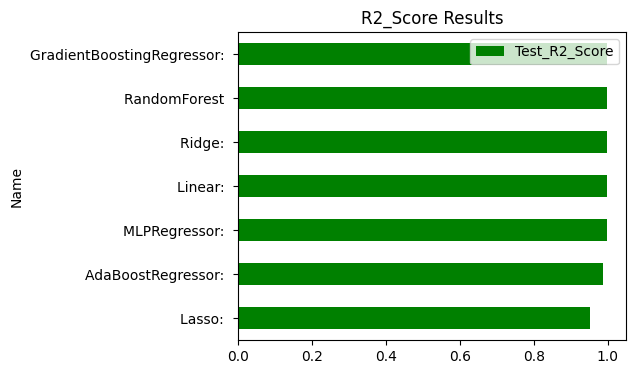

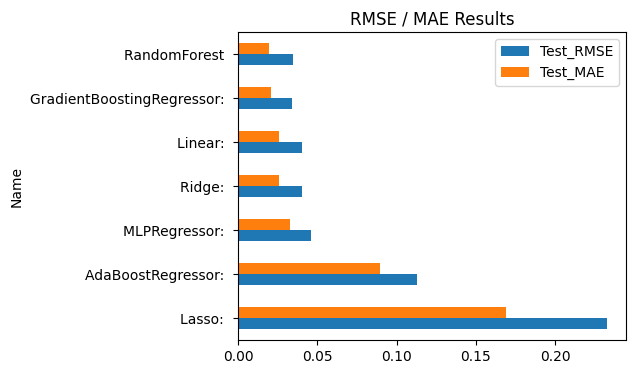

In [ ]:
evaluate(X_train,y_train,X_test,y_test).sort_values('Test_R2_Score').plot.barh(x="Name", y=['Test_R2_Score'], title = 'R2_Score Results', color='g',figsize= (5,4));
evaluate(X_train,y_train,X_test,y_test).sort_values('Test_MAE',ascending=False).plot.barh(x="Name", y=['Test_RMSE','Test_MAE'], title = 'RMSE / MAE Results',figsize= (5,4));


In [34]:
from sklearn.model_selection import GridSearchCV


Cross-validation and Hyperparameter Tuning

In [35]:
model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'max_features': ['sqrt', 'log2']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Metric to optimize
    n_jobs=-1  # Use all CPU cores
)

# Fit to data
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)


Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
